<b>Contents:</b>

[1 Load Dataset](#section_1)

[2  Load regions coordinates](#section_2)

[3 Regions with zero trips](#section_3)

[4  NYC static map visualization](#section_4)

[5  Count trips heatmap in may of 2016 from each region](#section_5)

[6  Filter and count average number of trips from each region](#section_6)

[7  Heatmap average number of trips from each region](#section_7)


In [1]:
import pandas as pd
import folium
import geojson
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import os
import time
from selenium import webdriver
from colour import Color

Used libraries: 
    - folium
    - geojson
    - PIL
    - os
    - selenium
    - colour
    
To crop images chromedriver.exe  must be placed in the executable directory 

<a id='section_1'></a>
# Load data

In [2]:
grouped=pd.read_csv('grouped.csv') #.drop(columns=['trip_duration', 'dropoff_datetime'])

In [3]:
grouped.head()

15  16  25  27  32  45  49  61  77  80  ...  2476  2478  2479  2481  2482  \
0   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0     0   
1   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0     0   
2   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0     0   
3   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0     0   
4   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0     0   

   2483  2484  2485  2486  2487  
0     0     0     0     0     0  
1     0     0     0     0     0  
2     0     0     0     0     0  
3     0     0     0     0     0  
4     0     0     0     0     0  

[5 rows x 1217 columns]

<a id='section_2'></a>
# Load regions coordinates


In [4]:
regions=pd.read_csv('regions.csv', sep=(';'))
regions.head()

region      west       east      south      north
0       1 -74.25559 -74.244478  40.496120  40.504508
1       2 -74.25559 -74.244478  40.504508  40.512896
2       3 -74.25559 -74.244478  40.512896  40.521285
3       4 -74.25559 -74.244478  40.521285  40.529673
4       5 -74.25559 -74.244478  40.529673  40.538061

<a id='section_3'></a>
# Regions with zero trips

In [5]:
# The full number of cells is 
regions.shape[0]
# Calculate the number of cells with no one trip
number_of_zero_trips=regions.shape[0]-grouped.shape[1]
print('The number of of cells with no one trip is '+str(number_of_zero_trips))

The number of of cells with no one trip is 1283


<a id='section_4'></a>
# NYC static map visualization

## Folium map generator

In [6]:
def generateBaseMap(default_location=[ 40.748817, -73.985428], default_zoom_start=11):
    base_map = folium.Map(location=default_location, tiles='cartodbpositron',
                          width=900, 
                          height=880, control_scale=True, 
                          zoom_start=default_zoom_start, 
                          no_touch=True,zoom_control=True )
    return base_map

## Create geojson file

In [7]:
def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
        geojson.Feature(geometry = geojson.Polygon([[(X['west'], X['south']),
                                                     (X['east'], X['south']),
                                                     (X['east'], X['north']),
                                                     (X['west'], X['north'])]]),
                        id = str(X.name),
                        properties=dict(name=X["region"],
                                            description=X["region"])))
    df.apply(insert_features, axis = 1)
    feature_collection = geojson.FeatureCollection(features)
    dumps = geojson.dumps(feature_collection)
    return geojson.loads(dumps)

In [8]:
geo_data = data2geojson(regions)


## Folium map generation

In [9]:
base_map = generateBaseMap()

# set grid to map
folium.Choropleth(geo_data = geo_data,
    fill_color = '#00000000',
    line_opacity=0.2).add_to(base_map)

# set marker of Empire State Building
folium.Marker([40.748817, -73.985428]).add_to(base_map)

# set text Empire State Building
folium.map.Marker(
    [40.748817, -73.985428],
    icon=folium.features.DivIcon(
        icon_size=(200,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 9pt; color: Maroon"><b>%s</b></div>' % 'Empire State Building',
        )
    ).add_to(base_map)

# visualize map
base_map

## Save and convert map to png format

In [10]:
def save_map(geomap):
    # Save map to html
    geomap.save('map.html')

    # Convert to png image format
    delay=5
    fn='map.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    base_map.save(fn)
    browser = webdriver.Chrome()
    browser.get(tmpurl)
    time.sleep(delay)
    browser.save_screenshot('map.png')

    # Crop image and save
    im = Image.open('map.png')
    width, height = im.size 
    left = 54
    top = 116
    right = width-left-6
    bottom = height

    im = im.crop((left, top, right, bottom))
    im.save('map_in_png.png')
    browser.quit()
    

In [11]:
save_map(base_map)

## Static map visualization function

In [12]:
# map visualization plot
def map_visualization(longitude, latitude,s=7):
    
    x_min=-74.25559
    x_max=-73.70001
    y_min=40.49612
    y_max=40.91553
    img = plt.imread('map_in_png.png')
    fig, ax = plt.subplots(figsize=(12, 12))
    fig.set_facecolor('.96')
    ax.imshow(img, extent = [x_min, x_max, y_min,y_max])
    ax.scatter(x=longitude, y=latitude, c='g' , s=s, label='Taxi pickup point')
    ax.legend(loc='upper left', fontsize=16)
    plt.title('New York city map', size=20, y=1.03)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    ax.xaxis.grid(True, which='major', linewidth=0.1,
    color='black', linestyle='--')
    ax.yaxis.grid(True, which='major', linewidth=0.1,
    color='black', linestyle='--')

## Static map

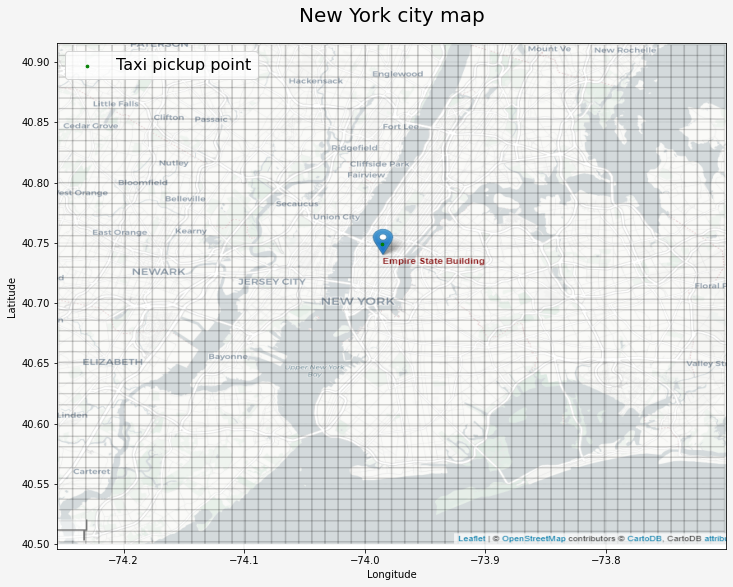

In [13]:
map_visualization(-73.985428, 40.748817)

## Check regions on static map

In [14]:
long_mean=(regions.west+regions.east)/2
lat_mean=(regions.south+regions.north)/2

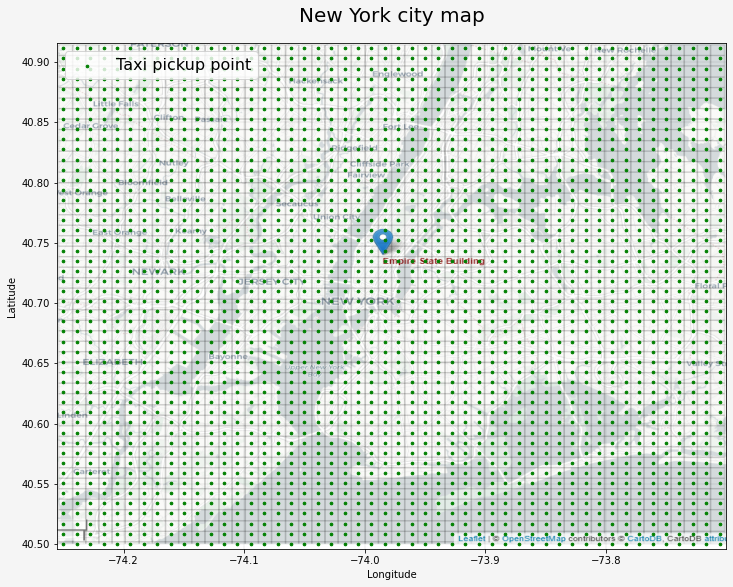

In [15]:
map_visualization(long_mean, lat_mean)

<a id='section_5'></a>
# Count trips heatmap in may of 2016 from each region

## Trips count from each region

In [16]:
grouped_count=grouped.sum().to_frame().reset_index().rename(columns={'index': 'region', 0:'count'})
grouped_count['count']=grouped_count['count'].astype('int')

grouped_count

region  count
0        15      1
1        16      1
2        25      1
3        27      1
4        32     19
...     ...    ...
1212   2483      2
1213   2484      1
1214   2485      2
1215   2486      3
1216   2487      3

[1217 rows x 2 columns]

## Heat map visualization

In [17]:
# create folium heatmap
base_map = generateBaseMap()
choropleth=folium.Choropleth(
    geo_data = geo_data,
    data=grouped_count,
    columns=['region', 'count'],
    key_on='feature.id',
    fill_color='YlOrBr',
    nan_fill_color='#00000000',
    fill_opacity=0.6,
    line_opacity=0.2,
    smooth_factor=3,
    legend_name='Taxi trips count',
    reset=True).add_to(base_map)
# set marker of Empire State Building
#folium.Marker([40.748817, -73.985428]).add_to(base_map)

# add popup of regions to determine the number of region
style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'], style=style_function, labels=False))


# set text Empire State Building
folium.map.Marker(
    [40.748817, -73.985428],
    icon=folium.features.DivIcon(
        icon_size=(200,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 9pt; color: Maroon"><b>%s</b></div>' % 'Empire State Building',
        )
    ).add_to(base_map)
folium.LayerControl().add_to(base_map)

In [18]:
base_map

In [20]:
save_map(base_map)

In [21]:
trips_data = np.array(grouped_count['count'])
coord_data = np.array(regions)

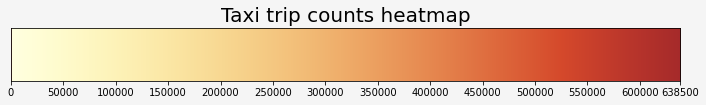

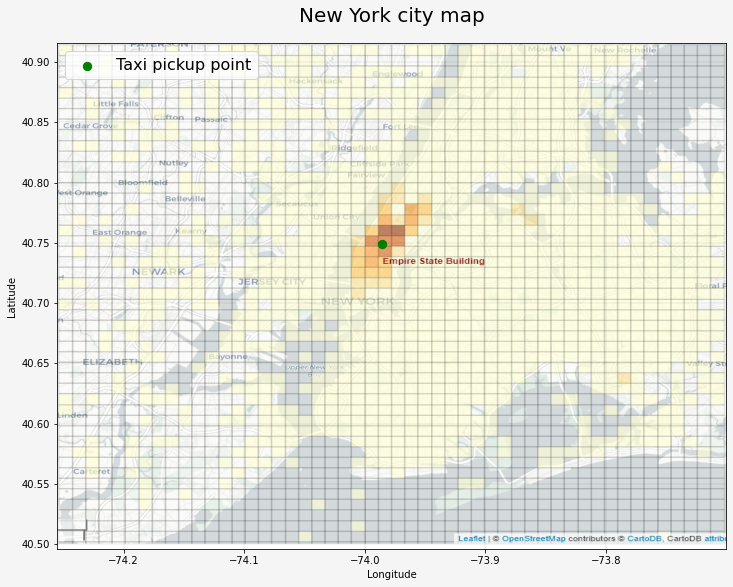

In [22]:
# create static heatmap

# define colors
color_1 = 'LightYellow'
color_2 = 'Brown'
color_1 = Color(color_1)
grad = list(color_1.range_to(Color(color_2), int(trips_data.max())))
# Heatmap
fig, ax = plt.subplots(figsize=(12, 1.5))
fig.set_facecolor('.96')
trips_values = list(range(0, int(trips_data.max())+1, 500))
colorbar = np.array([[tuple([int(round(j*255, 0)) for j in grad[int(i)-1].rgb]) for i in trips_values] for _ in range(100)])
ax.imshow(colorbar)
plt.yticks([])
ticks = list(range(len(trips_values)))
plt.xticks(ticks=ticks[::100] + [ticks[-1]], labels=trips_values[::100] + [trips_values[-1]])
plt.title('Taxi trip counts heatmap', y=1.01, fontsize=20)
plt.show()
map_visualization(-73.985428, 40.748817, 70)

<a id='section_6'></a>
# Filter and count average number of trips from each region

In [23]:
grouped_mean=grouped.mean().to_frame().reset_index().rename(columns={'index': 'region', 0:'mean'})
grouped_mean['mean']=grouped_mean['mean'].astype('int')
grouped_mean=grouped_mean[grouped_mean['mean']>=5]
grouped_mean

region  mean
344    1075    66
345    1076   138
346    1077    86
379    1125    66
380    1126   181
...     ...   ...
1031   2068    95
1032   2069    10
1058   2118   146
1059   2119    34
1084   2168    68

[102 rows x 2 columns]

<a id='section_7'></a>
# Heatmap average number of trips from each region

## Heatmap visualization

In [24]:
# create folium heatmap
base_map = generateBaseMap()
choropleth=folium.Choropleth(
    geo_data = geo_data,
    data=grouped_mean,
    columns=['region', 'mean'],
    key_on='feature.id',
    fill_color='YlOrBr',
    nan_fill_color='#00000000',
    fill_opacity=0.6,
    line_opacity=0.2,
    smooth_factor=3,
    legend_name='Taxi trips count',
    reset=True).add_to(base_map)

#set marker of The Statue of Liberty
folium.Marker([40.689247, -74.044502]).add_to(base_map)

# add popup of regions to determine the number of region
style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'], style=style_function, labels=False))

folium.TileLayer('openstreetmap').add_to(base_map)
# set text Empire State Building
folium.map.Marker(
    [40.689247, -74.044502],
    icon=folium.features.DivIcon(
        icon_size=(200,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 9pt; color: Maroon"><b>%s</b></div>' % 'The Statue of Liberty',
        )
    ).add_to(base_map)
folium.LayerControl().add_to(base_map)

In [25]:
base_map

## The number regions with more than 5 average trips per hour

In [26]:
print('The number of regions after filtering is '+str(len(grouped_mean)))

The number of regions after filtering is 102


In [28]:
grouped_mean.region.unique()

array(['1075', '1076', '1077', '1125', '1126', '1127', '1128', '1129',
       '1130', '1131', '1132', '1172', '1173', '1174', '1175', '1176',
       '1177', '1178', '1179', '1180', '1181', '1182', '1183', '1184',
       '1221', '1222', '1223', '1224', '1225', '1227', '1228', '1229',
       '1230', '1231', '1232', '1233', '1234', '1235', '1272', '1273',
       '1274', '1278', '1279', '1280', '1281', '1282', '1283', '1284',
       '1285', '1286', '1287', '1326', '1327', '1331', '1332', '1333',
       '1334', '1335', '1336', '1337', '1338', '1339', '1376', '1377',
       '1378', '1380', '1382', '1383', '1384', '1385', '1386', '1387',
       '1388', '1389', '1390', '1426', '1431', '1434', '1435', '1436',
       '1437', '1438', '1439', '1441', '1442', '1480', '1482', '1483',
       '1530', '1532', '1533', '1580', '1630', '1684', '1733', '1734',
       '1783', '2068', '2069', '2118', '2119', '2168'], dtype=object)

In [29]:
len(grouped_mean.region)

102